In [1]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [1]:
using CUDA

# Memory management

This notebook focusses on how to manage GPU memory from the host. With Julia being a garbage-collected langauge, there are some specific considerations to take into account to avoid excessive memory pressure that could impact performance.

Let's start with having a look at our device's memory capabilities:

In [2]:
CUDA.total_memory() |> Base.format_bytes

"15.744 GiB"

In [3]:
CUDA.available_memory() |> Base.format_bytes

"13.222 GiB"

There's different kind of memories that can be allocated with the CUDA APIs:

1. device memory: located on and accessible from a single GPU
2. unified memory: memory accessible from any processor in the system
3. host memory: located on the CPU, can be made accessible to the GPU
4. array memory: opaque, padded memory for use with textures

## Low-level interface

Each of these can be allocated using the `Mem.alloc` function from CUDA.jl, resulting in an `<:AbstractBuffer` object encoding the type and size of the allocated memory:

In [4]:
dev_buf = Mem.alloc(Mem.DeviceBuffer, sizeof(Int))

DeviceBuffer(8 bytes at 0x0000000200c00000)

In [5]:
unified_buf = Mem.alloc(Mem.UnifiedBuffer, sizeof(Int))

UnifiedBuffer(8 bytes at 0x0000001700000000)

In [6]:
host_buf = Mem.alloc(Mem.HostBuffer, sizeof(Int))

HostBuffer(8 bytes at 0x00000009e0c00000)

Since the GPU or CPU doesn't care about what _kind_ of buffer this is, but only whether it can access it, we then convert these buffers to pointers to be able to actually use the allocated memory. In order to discern between pointers that can be read on the CPU or GPU, we've introduced a new pointer type `CuPtr` representing GPU pointers:

In [7]:
dev_ptr = convert(CuPtr{Int}, dev_buf)

CuPtr{Int64}(0x0000000200c00000)

Performing an illegal conversion will trigger an exception:

In [8]:
convert(Ptr{Int}, dev_buf)

LoadError: ArgumentError: Illegal conversion of a CUDA.Mem.DeviceBuffer to a Ptr{Int64}

Unified memory is accessible on both the CPU and GPU, so we can convert to both a `CuPtr` and a `Ptr`:

In [9]:
unified_gpu_ptr = convert(CuPtr{Int}, unified_buf)

CuPtr{Int64}(0x0000001700000000)

In [10]:
unified_cpu_ptr = convert(Ptr{Int}, unified_buf)

Ptr{Int64} @0x0000001700000000

Notice that the actual addresses are identical because of CUDA's Unified Virtual Addressing (UVA).

Finally, host buffers are by default only accessible from the CPU, and are use to allocate page locked memory. More on that later.

In [11]:
host_cpu_ptr = convert(Ptr{Int}, host_buf)

Ptr{Int64} @0x00000009e0c00000

However, host memory can also be *mapped*, which allows the memory to be accessed from the GPU. These accesses are slow though, as they always go across the PCI bus (as opposed to unified memory, which only migrates to or from the GPU when a page fault occurs).

In [12]:
host_buf = Mem.alloc(Mem.HostBuffer, sizeof(Int), Mem.HOSTALLOC_DEVICEMAP)

HostBuffer(8 bytes at 0x00000009e0c00200)

In [13]:
host_cpu_ptr = convert(Ptr{Int}, host_buf)

Ptr{Int64} @0x00000009e0c00200

In [14]:
host_gpu_ptr = convert(CuPtr{Int}, host_buf)

CuPtr{Int64}(0x00000009e0c00200)

This type of so-called *zero copy memory* (because the GPU can directly write to CPU memory without requiring a dedicated copy) can be interesting to implement communication between the GPU and the CPU, e.g., for the CPU to keep track of kernel progress, or to determine if the kernel should keep on running. But don't use it for regular memory copying, as the memory operations are very high-latency and could wreck kernel performance.

### Accessing memory

The easiest way to access this memory, is by wrapping an array around it. Let's demonstrate using the unified memory, which is accessible from both the CPU and the GPU:

In [15]:
unified_cpu_arr = unsafe_wrap(Array, unified_cpu_ptr, 1)

1-element Vector{Int64}:
 0

In [16]:
unified_gpu_arr = unsafe_wrap(CuArray, unified_gpu_ptr, 1)

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 0

Modification of these arrays behaves as expected:

In [17]:
unified_cpu_arr .= 42

1-element Vector{Int64}:
 42

In [18]:
unified_gpu_arr

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 42

### Freeing memory

Since we've manually allocated memory, we're also responsible for freeing it when unused:

In [19]:
Mem.free(dev_buf)
Mem.free(unified_buf)
Mem.free(host_buf)

## Stream-ordered allocator

With the essentials of the low-level API out of the way, let's focus on a couple of interesting specifics. The first is how device memory operations (allocating, freeing) are executed. Before CUDA 11.2, these operations were synchronizing and required the entire GPU context to be idle. This was a problem especially because Julia's GC could decide to free memory at any point in time, grinding the GPU to a halt.

We worked around this using memory pools that cache allocations, but since CUDA 11.2 there is the stream-ordered allocator which makes it possible to asynchronously allocate and free memory, ordered against specific streams. **This greatly improves performance, and is an important reason to use a driver with CUDA capability 11.2 or higher!** Support for this allocator also depends on your device:

In [20]:
attribute(device(), CUDA.DEVICE_ATTRIBUTE_MEMORY_POOLS_SUPPORTED)

1

It's still possible to use the old, synchronizing allocator by passing `async=false` to `Mem.alloc`:

In [21]:
buf = Mem.alloc(Mem.DeviceBuffer, sizeof(Int); async=false)
Mem.free(buf)  # the buffer knows which allocator it uses

Alternatively, if Julia is started with the environment variable `JULIA_CUDA_MEMORY_POOL` set to `none`, all of CUDA.jl will use the old allocator. Note that the only supported values for this environment variable are `none` or `cuda` (for the stream-ordered allocator); the old memory pools (`binned`, `split`, etc) have been removed.

Like any other GPU functionality in CUDA.jl, memory operations will be ordered against the task-local stream. That implies that you cannot allocate memory on one task and use it in another without synchronization; more on that in the concurrent GPU computing notebook.

### Memory pools

The stream-ordered allocator also caches memory allocations for future reuse. This can be inspected using the `cached_memory` function (only supported on CUDA 11.3 or higher):

In [22]:
CUDA.used_memory() |> Base.format_bytes

"0 bytes"

In [23]:
CUDA.cached_memory() |> Base.format_bytes

"32.000 MiB"

These values can be inspected together with the device-wide memory usage (including allocations from other applications, or from allocations that did not use the stream-ordered allocator):

In [24]:
CUDA.memory_status()

Effective GPU memory usage: 16.21% (2.553 GiB/15.744 GiB)
Memory pool usage: 0 bytes (32.000 MiB reserved)

By default, only a small amount of memory is cached, and it will be released as soon as the device is synchronized. Depending on the application, it might be interesting to hold on to more memory. This can be done by setting [an attribute](https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__TYPES.html#group__CUDA__TYPES_1g5af6ea9ddd7633be98cb7de1bbf1d9f0) on the memory pool:

In [25]:
pool = memory_pool(device())
attribute(UInt64, pool, CUDA.MEMPOOL_ATTR_RELEASE_THRESHOLD)

0x0000000000000000

Alternatively, the memory pool can be replaced altogether using the `memory_pool!` function. Do note that we currently use the device's default memory pool for interoperability's sake: If other applications or libraries use the default pool too, allocations can be shared between both environments, and competition between independent memory caches is avoided.

## Array abstraction

Of course, instead of allocating buffers and wrapping an array around it, it's much easier to just start with an array and expect its constructor to allocate the necessary memory:

In [26]:
gpu_arr = CuArray{Int}(undef, 1)

1-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 0

As you can see, this allocated a `DeviceBuffer`, yielding a familiar `CuPtr`:

In [27]:
pointer(gpu_arr)

CuPtr{Int64}(0x0000000200c00000)

This memory is managed automatically, and will be released when it is unreachable and marked by Julia's garbage collector.

For other kinds of memory, you can specify the buffer type variable:

In [28]:
unified_arr = CuArray{Int,1,Mem.UnifiedBuffer}(undef, 1)

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 0

If you want page-locked host memory, you can also use a regular Julia array and `pin` it retroactively (more on that later):

In [29]:
host_arr = Array{Int}(undef, 1)
Mem.pin(host_arr)

1-element Vector{Int64}:
 2

### Early freeing memory

Even though Julia's garbage collector will eventually sweep unused `CuArray` objects causing it to free device memory, this may take a long time. This is exacerbated by the fact that Julia's CPU-based GC doesn't *sense* GPU memory pressure, so it won't run more frequently when you're using lots of GPU memory.

To help reduce memory pressure, CUDA.jl makes it possible to *early free* memory (making sure we don't double-free when the garbage collector eventually comes by):

In [30]:
temp = CuArray{Int}(undef, 1)
CUDA.unsafe_free!(temp)
temp = nothing;

Calling `unsafe_free!` immediately releases the associated GPU buffer, so you cannot use the array object afterwards, or you *will* run into fatal memory errors. Even though this means `unsafe_free!` is a dangerous tool, it can often be used safely and effectively in library functions a la:

In [31]:
function myLibraryFunction(a::CuArray)
    workarea = similar(a)
    expensive_operation(a, workarea)
    CUDA.unsafe_free!(workarea)
    return a
end;

Although it is expected that the Julia compiler will gain optimizations to perform early finalization automatically, for now calling `unsafe_free!` is often a great help to reduce memory pressure in allocation-heavy code.

Using `unsafe_free!` can also improve performance of concurrent applications, because it will free on the current stream. When the garbage collector frees memory, there is no stream to order against (as the GC uses its own task) so operations need to be ordered against all streams, not just the one the array was being used on. More on this in the concurrent GPU computing notebook.

## Unified memory

As shown above, you can construct a `CuArray` backed by unified memory by setting the buffer type variable to `Mem.UnifiedBuffer`:

In [32]:
unified_arr = CuArray{eltype(host_arr),ndims(host_arr),Mem.UnifiedBuffer}(host_arr)

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 2

Alternatively, there is an experimental keyword argument that can be passed to the `cu` function -- the convenience function to upload CPU memory to the GPU:

In [33]:
unified_arr = cu(host_arr; unified=true)

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 2

This kind of memory is especially interesting for multi-GPU computing, as right now CUDA.jl doesn't (yet) track array ownership, and you need to make sure you only use memory on the device you allocated it on!

In [34]:
device!(0)
temp = CuArray{Int}(undef, 1)
device!(1) do
    # cannot use `temp` here!
end

With unified memory, this is possible:

In [35]:
fill!(unified_arr, 0)
device!(0) do
    unified_arr .+= 21
    synchronize()
end
device!(1) do
    unified_arr .*= 2
    synchronize()
end
unified_arr

1-element CuArray{Int64, 1, CUDA.Mem.UnifiedBuffer}:
 42

We can even access the memory *directly* on the CPU (i.e., without copying first)!

In [36]:
cpu_arr = unsafe_wrap(Array,
                      reinterpret(Ptr{eltype(unified_arr)},
                                  pointer(unified_arr)),
                      size(unified_arr))

1-element Vector{Int64}:
 42

## Pinned memory

Host memory allocated by CUDA using `Mem.alloc(HostBuffer)`, or by Julia and retroactively pinned using `Mem.pin`, is page-locked: The operating system cannot page this memory out to disk, making it possible for the CUDA APIs to perform operations asynchronously (e.g. by DMAing without the CPU having to wait).

With unpinned memory CUDA first targets a staging buffer before doing a DMA to or from the device:

```
a = Array(...)
b = CuArray(a)
consume(b)
```

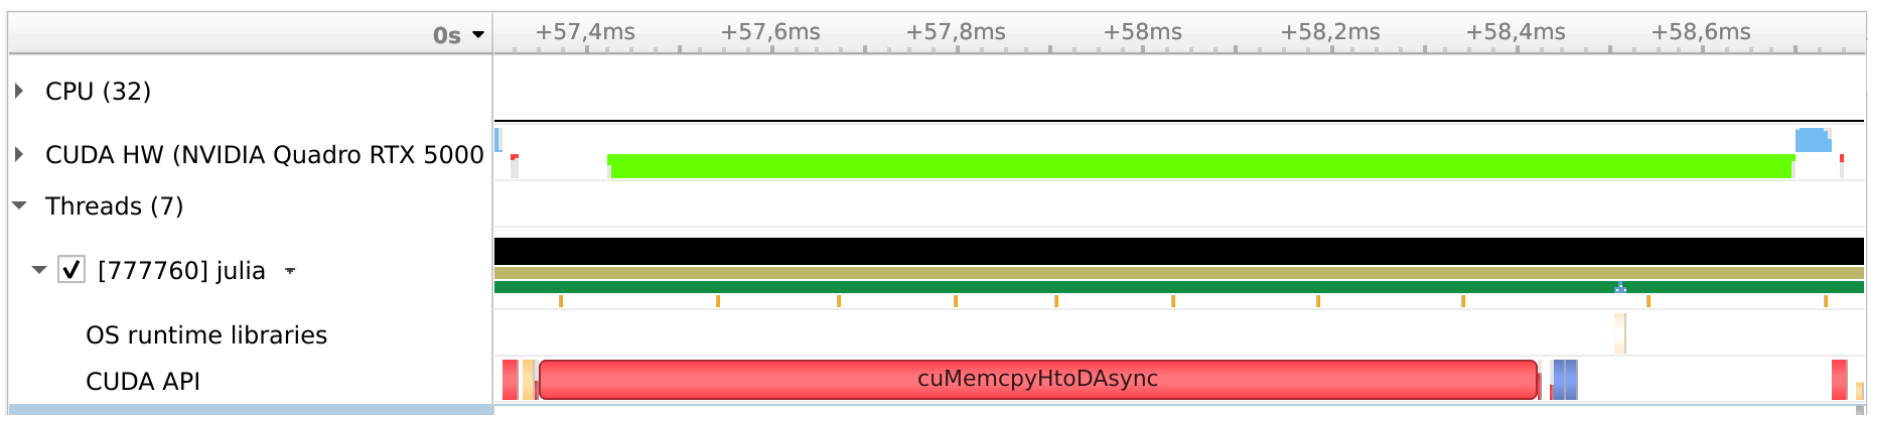

This has several disadvantages:
- the copy does not start right away; as there need to be some data in the staging buffer
- the CPU is kept busy during the copy (complicating concurrent GPU computing)

If instead we copy to a pinned buffer, the copy operation starts straight away without keeping the CPU busy:

```
a = Array(...)
Mem.pin(a)
b = CuArray(a)
consume(b)
```

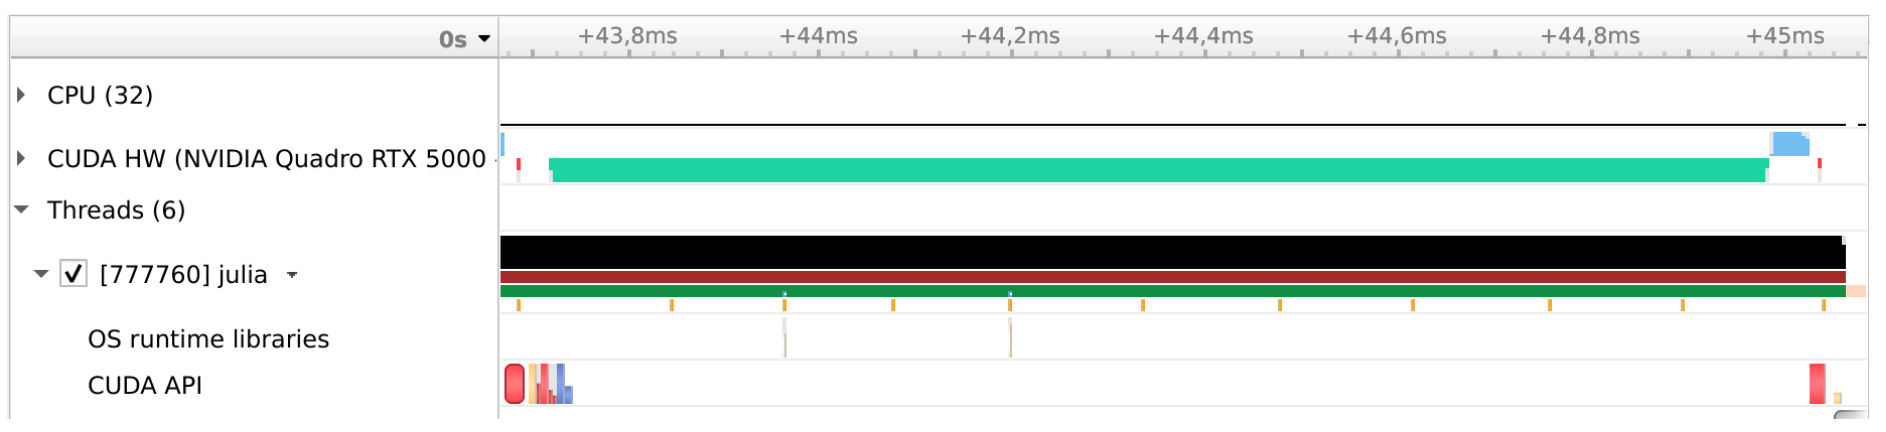

This not only avoids blocking the CPU, but may also speed up the operation by avoiding the copy to a staging buffer.

There is no free lunch, of course:

- pinning memory is expensive, so make sure to pre-allocate and pin the necessary buffers beforehand
- pinning too much memory will reduce overall system performance

## Textures

Textures are read-only, global memory buffers that are optimized for image-like operations:
- memory reads use a special cache optimized for spatial locality (in coordinate space)
- dedicated filtering hardware makes certain operations really cheap

CUDA's hardware support for textures is fairly limited, e.g., it only supports 1, 2 or 4 channels, so let's use an RGBA test image.

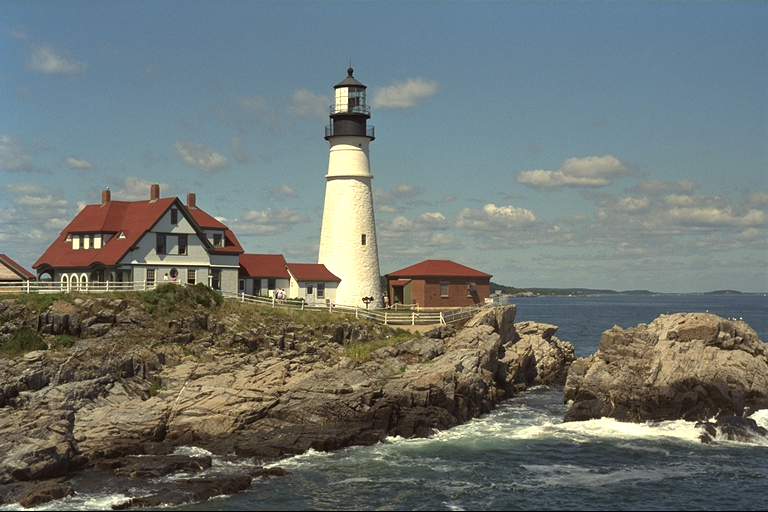

In [37]:
using Images, TestImages, ColorTypes, FixedPointNumbers
img = RGBA{N0f8}.(testimage("lighthouse"))

CUDA.jl also only supports "plain" datatypes (scalars, of tuples of scalars), so we reinterpret our image:

In [38]:
img′ = reinterpret(NTuple{4,UInt8}, img);

To use this image as a texture on the device, we need to create a `CuTexture` object. These objects take a data source, either a `CuArray`, or a `CuTextureArray` which is an opaque, pitched array that can be read more efficiently.

In [39]:
texturearray = CuTextureArray(img′);
texture = CuTexture(texturearray; normalized_coordinates=true)

512×768 4-channel CuTexture(::CuTextureArray) with eltype NTuple{4, UInt8}

Now we can pass this texture to a kernel. Note that I chose to use normalized coordinates, which means we'll index the texture using values in `[0,1]`.

In [40]:
function warp(dst, texture)
    tid = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    I = CartesianIndices(dst)
    @inbounds if tid <= length(I)
        i,j = Tuple(I[tid])
        u = Float32(i-1) / Float32(size(dst, 1)-1)
        v = Float32(j-1) / Float32(size(dst, 2)-1)
        x = u + 0.02f0 * sin(30v)
        y = v + 0.03f0 * sin(20u)
        dst[i,j] = texture[x,y]
    end
    return
end

# the size of the destination determines how much we warp
outimg_d = CuArray{eltype(img′)}(undef, 500, 1000);

We then use the occupancy API to determine a launch configuration:

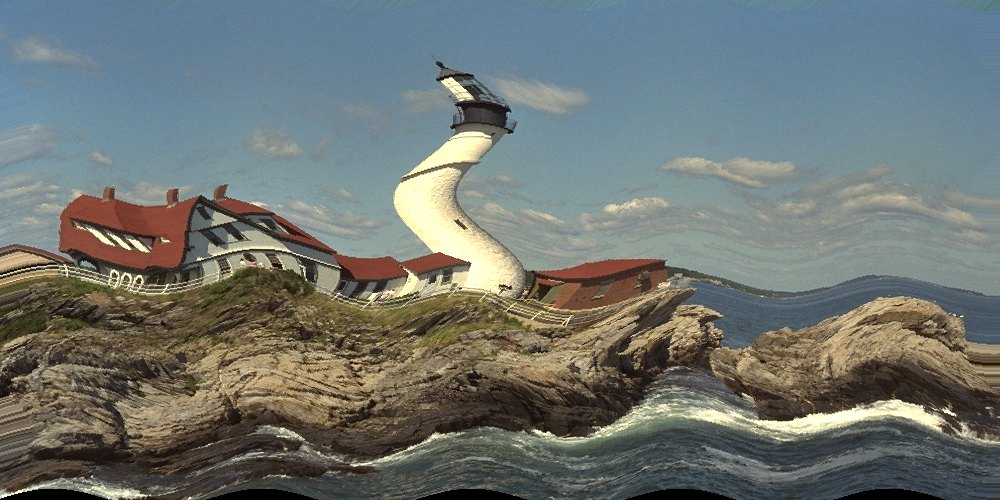

In [41]:
kernel = @cuda launch=false warp(outimg_d, texture)
config = launch_configuration(kernel.fun)
threads = min(length(outimg_d), config.threads)
blocks = cld(length(outimg_d), threads)
kernel(outimg_d, texture; threads, blocks)

outimg = Array(outimg_d)
reinterpret(eltype(img), outimg)

### Clamping

By default, CUDA.jl uses the clamping address mode which repeats the last pixel when going out of bounds. There are several [other clamping modes](https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__TYPES.html#group__CUDA__TYPES_1gc925457ee7128d6251071f6ff7608887) you can use: border, mirror and wrap.

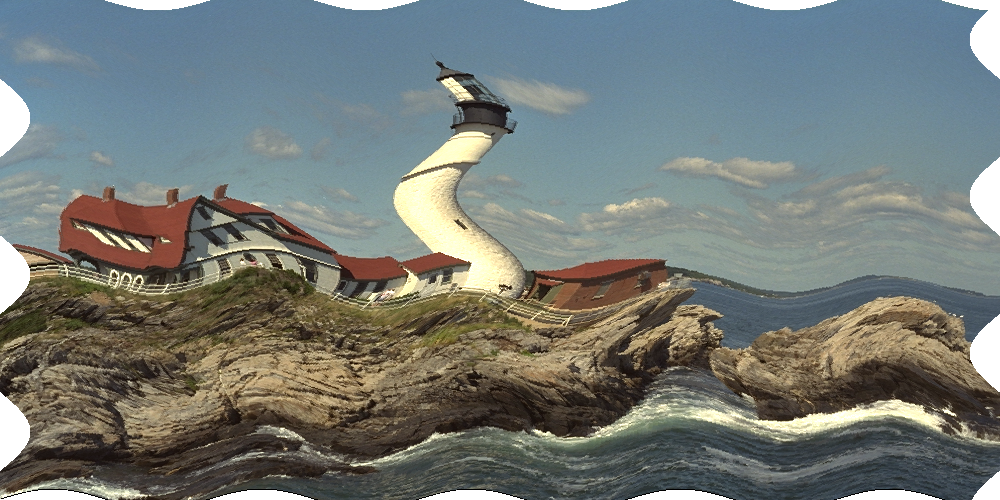

In [42]:
texture = CuTexture(texturearray; normalized_coordinates=true, address_mode=CUDA.ADDRESS_MODE_BORDER)
kernel(outimg_d, texture; threads, blocks)
outimg = Array(outimg_d)
reinterpret(eltype(img), outimg)

### Generalized interpolations

CUDA's hardware only supports a number of interpolation modes: nearest-neighbour, and linear. CUDA.jl extends that by implementing additional filtering modes, currently only cubic interpolation, on top of the hardware-accelerated ones. For example:

In [43]:
texture = CuTexture(texturearray; interpolation=CUDA.CubicInterpolation())

512×768 4-channel CuTexture(::CuTextureArray) with eltype NTuple{4, UInt8}

In [44]:
# cubic interpolation is currently only implemented for non-normalized coordinates
function warp2(dst, texture)
    tid = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    I = CartesianIndices(dst)
    @inbounds if tid <= length(I)
        i,j = Tuple(I[tid])
        u = Float32(i-1) / Float32(size(dst, 1)-1)
        v = Float32(j-1) / Float32(size(dst, 2)-1)
        x = u + 0.02f0 * sin(30v)
        y = v + 0.03f0 * sin(20u)
        dst[i,j] = texture[1+size(texture, 1)*x,
                           1+size(texture, 2)*y]
    end
    return
end

# the size of the destination determines how much we warp
outimg_d = CuArray{eltype(img′)}(undef, 500, 1000);

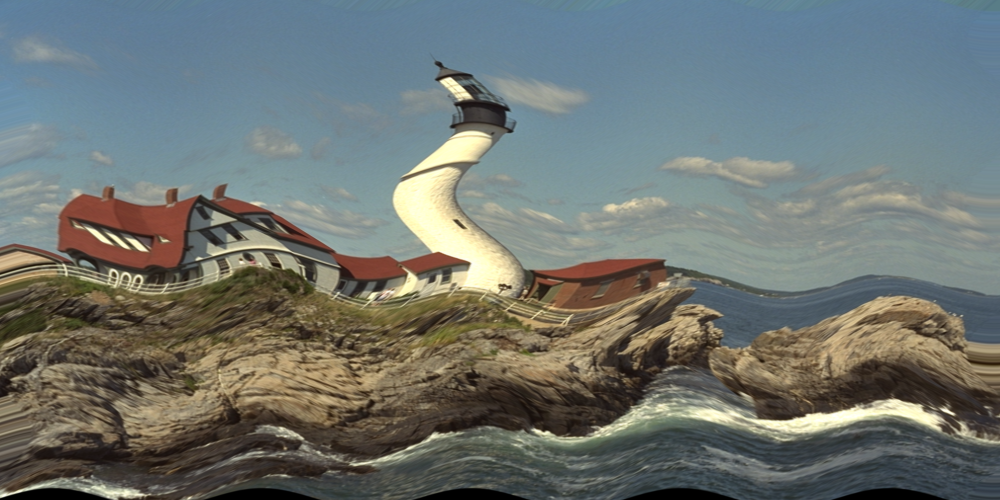

In [45]:
kernel = @cuda launch=false warp2(outimg_d, texture)
config = launch_configuration(kernel.fun)
threads = min(length(outimg_d), config.threads)
blocks = cld(length(outimg_d), threads)
kernel(outimg_d, texture; threads, blocks)

outimg = Array(outimg_d)
reinterpret(eltype(img), outimg)

## Memory copying

When you call `Array(::CuArray)` or vice versa, there are several functions involved:

1. `copyto!` taking an array, performing bounds checks
2. `unsafe_copyto!` taking an array, copying the array's data and metadata
3. `unsafe_copyto!` taking pointers, performing the actual memory copying

There is generally no reason to use any of these lower-level methods, with one exception.

### Pitched arrays

CUDA supports pitched arrays -- arrays whose row size includes padding:

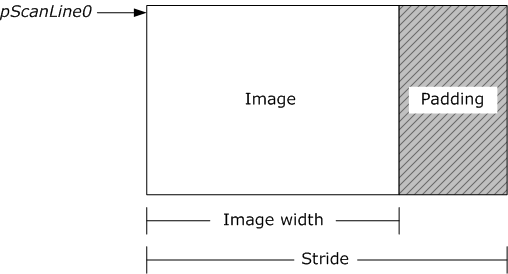

To work with these arrays, there are specialized 2D and 3D `memcpy` functions that take strides into account. Although CUDA.jl does not support pitched arrays, the specialized memory copy routines can be useful to copy several slices of an array at once, e.g., to modify parts of a matrix.

In [46]:
A = CUDA.zeros(Int, 5, 10)

5×10 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0

In [47]:
B = ones(Int, 3, 8)

3×8 Matrix{Int64}:
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

In [48]:
Mem.unsafe_copy2d!(pointer(A), Mem.DeviceBuffer, pointer(B), Mem.HostBuffer,
                   size(B, 1), size(B, 2); dstPos=(2,2),
                   dstPitch=stride(A, 2)*sizeof(Int))
A

5×10 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  1  0
 0  0  0  0  0  0  0  0  0  0

This can be useful to improve performance, since it only requires a single API call for what would otehrwise have consisted of multiple individual copies of linear memory. A similar function exists for 3D copies.